/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/2887609788.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
[*********************100%***********************]  10 of 10 completed
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/2887609788.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()
[*********************100%***********************]  10 of 10 completed

Processing pair: IEMG & EEM
Processing pair: ARKK & ARKW
Processing pair: TLT & SPTL
Processing pair: SHY & VGSH
Processing pair: SOXX & ITA
Processing pair: IEMG & EEM
Processing pair: ARKK & ARKW
Processing pair: TLT & SPTL
Processing pair: SHY & VGSH
Processing pair: SOXX & ITA
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=

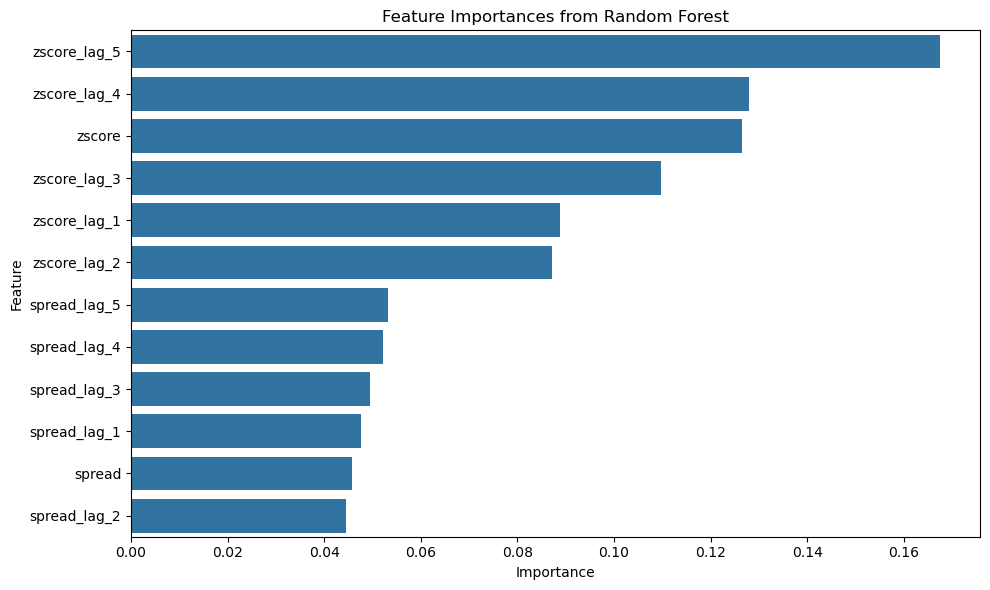

In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define ETF pairs and date ranges
# -----------------------------
etf_pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]
downloadable_tickers = list(set([etf for pair in etf_pairs for etf in pair]))

train_start = "2015-01-01"
train_end = "2020-01-01"
test_start = "2020-01-02"
test_end = "2024-12-31"

# -----------------------------
# 2. Download training and testing data
# -----------------------------
train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()

# -----------------------------
# 3. Function to process a pair
# -----------------------------
def process_pair(etf1, etf2, price_data, lookback=60):
    df = pd.DataFrame(index=price_data.index)
    df["etf1"] = price_data[etf1]
    df["etf2"] = price_data[etf2]

    df["hedge_ratio"] = (
        df["etf1"].rolling(lookback).cov(df["etf2"]) /
        df["etf2"].rolling(lookback).var()
    )

    df["spread"] = df["etf1"] - df["hedge_ratio"] * df["etf2"]
    spread_mean = df["spread"].rolling(lookback).mean()
    spread_std = df["spread"].rolling(lookback).std()
    df["zscore"] = (df["spread"] - spread_mean) / spread_std

    for i in range(1, 6):
        df[f"spread_lag_{i}"] = df["spread"].shift(i)
        df[f"zscore_lag_{i}"] = df["zscore"].shift(i)

    df["target"] = (
        (df["zscore"].shift(-1).abs() < df["zscore"].abs()).astype(int)
    )

    df["pair"] = f"{etf1}_{etf2}"
    return df.dropna()

# -----------------------------
# 4. Process all pairs (train and test)
# -----------------------------
def process_all_pairs(pairs, price_data):
    processed = []
    for etf1, etf2 in pairs:
        print(f"Processing pair: {etf1} & {etf2}")
        df = process_pair(etf1, etf2, price_data)
        processed.append(df)
    return pd.concat(processed)

train_df = process_all_pairs(etf_pairs, train_prices)
test_df = process_all_pairs(etf_pairs, test_prices)

# -----------------------------
# 5. Feature columns
# -----------------------------
feature_cols = [
    'spread', 'zscore',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

X_train = train_df[feature_cols]
y_train = train_df["target"]

X_test = test_df[feature_cols]
y_test = test_df["target"]

# -----------------------------
# 6. Grid Search to Tune Model
# -----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# -----------------------------
# 7. Predict on Test Set
# -----------------------------
y_pred = best_rf.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("True Label Distribution:", Counter(y_test))
print("Predicted Label Distribution:", Counter(y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 8. Feature Importance
# -----------------------------
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()


In [45]:
from sklearn.metrics import accuracy_score
from collections import Counter


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("True Label Distribution:", Counter(y_test))
print("Predicted Label Distribution:", Counter(y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.64      2429
           1       0.73      0.78      0.75      3241

    accuracy                           0.71      5670
   macro avg       0.70      0.70      0.70      5670
weighted avg       0.71      0.71      0.71      5670

Accuracy: 0.7088183421516755
True Label Distribution: Counter({1: 3241, 0: 2429})
Predicted Label Distribution: Counter({np.int64(1): 3474, np.int64(0): 2196})


Exception ignored in: <function ResourceTracker.__del__ at 0x1048d1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103159bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1081a5bc0>
Traceback (most recent call last

## 📈 Mean Reversion Classification Report

- **Accuracy**: 71.0%  
  The model correctly classifies mean reversion signals ~71% of the time.

### 🔍 Class Details
- **Class 0 (No Mean Reversion Signal)**
  - Precision: 68% — Of all times the model predicted "no signal", 68% were correct.
  - Recall: 61% — Of all actual "no signal" cases, 61% were correctly identified.
  - F1-Score: 64% — A balance between precision and recall.

- **Class 1 (Mean Reversion Signal Present)**
  - Precision: 73% — Of all times the model predicted "signal present", 73% were correct.
  - Recall: 78% — Of all actual signals, 78% were identified correctly.
  - F1-Score: 75% — Stronger ability to detect mean reversion events.

### ⚖️ Class Distribution
- **True Labels**:
  - Class 1 (Signal): 3,241  
  - Class 0 (No Signal): 2,429

- **Predicted Labels**:
  - Class 1 (Signal): 3,474  
  - Class 0 (No Signal): 2,196

💡 **Interpretation**:  
The model is better at detecting **mean reversion signals** than identifying when there is no signal — useful if you're more concerned with **capturing potential trades** than avoiding false alerts.


/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355

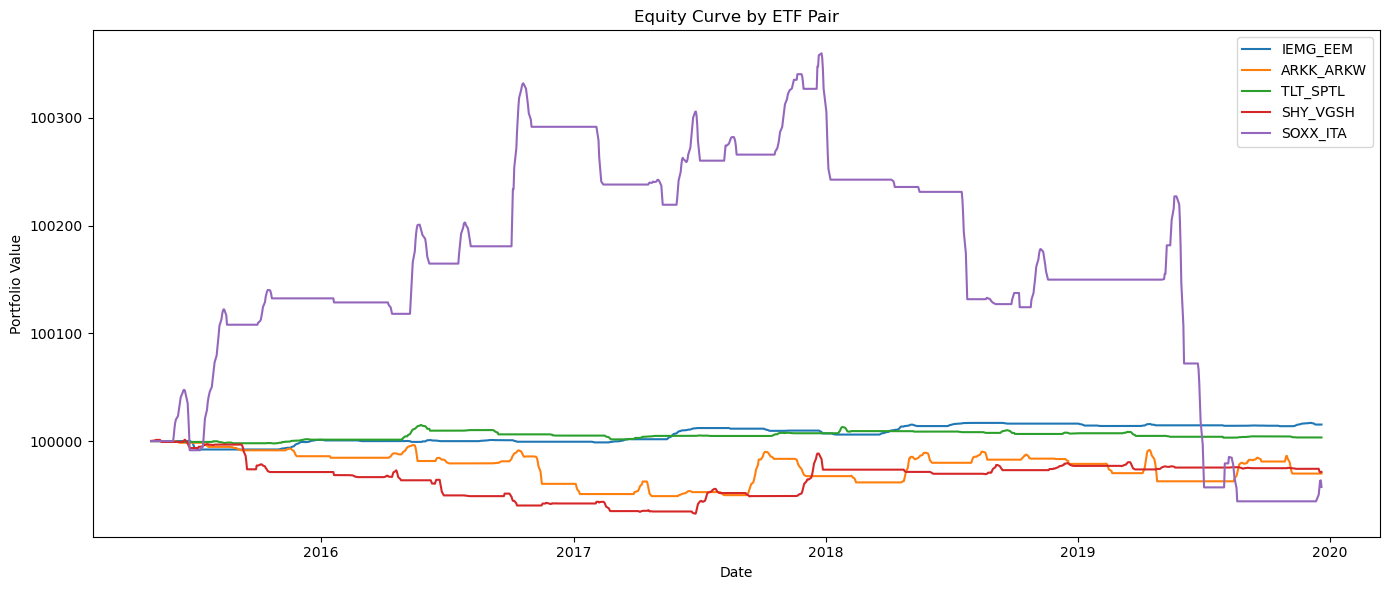


🔢 Final Portfolio Value: $499,917.42

📊 Trade Summary per Pair:
  IEMG_EEM: 299 trades | Total PnL: $15.35 | Avg PnL: $0.05
  ARKK_ARKW: 290 trades | Total PnL: $-30.13 | Avg PnL: $-0.10
  TLT_SPTL: 247 trades | Total PnL: $3.37 | Avg PnL: $0.01
  SHY_VGSH: 276 trades | Total PnL: $-28.60 | Avg PnL: $-0.10
  SOXX_ITA: 286 trades | Total PnL: $-42.57 | Avg PnL: $-0.15


/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()



📈 Year-End Portfolio Values:
2015-12-31    500092.171116
2016-12-31    500198.533170
2017-12-31    500282.341620
2018-12-31    500129.052693
2019-12-31    499917.420823
Freq: YE-DEC, dtype: float64


/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_values = equity_series.resample('Y').last()
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/975517030.py:88: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = combined_equity.resample('Y').last()


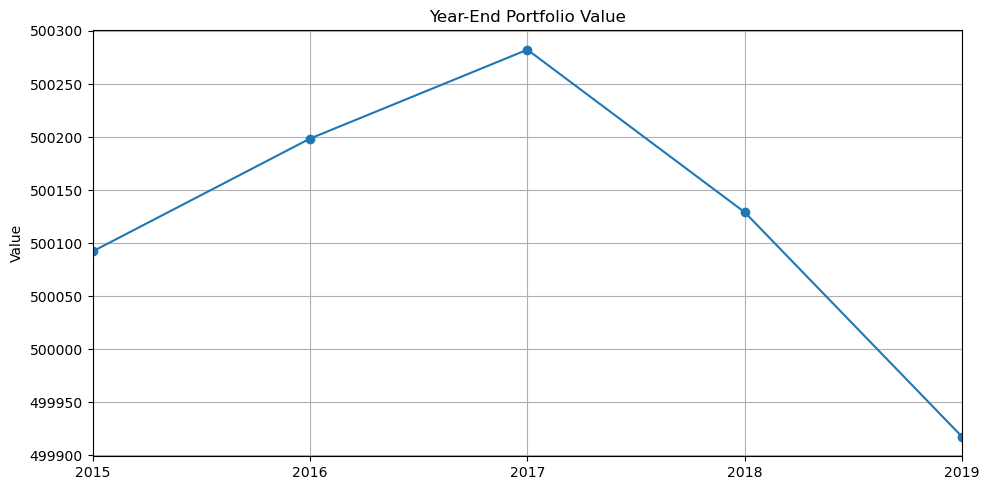

In [41]:

# -----------------------------
# 10. Simulate Trading Strategy (Mock Portfolio)
# -----------------------------
from collections import defaultdict

def simulate_portfolio_with_stats(df, model, feature_cols, initial_cash=100000, holding_period=5, entry_threshold=1.5):
    df = df.copy()
    df['prediction'] = model.predict(df[feature_cols])
    df['position'] = 0
    cash = initial_cash
    equity_curve = []
    equity_dates = []

    trade_count = 0
    trade_pnls = []
    trade_dates = []

    for i in range(len(df) - holding_period):
        current_row = df.iloc[i]
        date = df.index[i]

        if current_row["prediction"] == 1 and abs(current_row["zscore"]) > entry_threshold:
            entry_spread = current_row["spread"]
            exit_spread = df.iloc[i + holding_period]["spread"]
            direction = -1 if current_row["zscore"] > 0 else 1

            pnl = direction * (entry_spread - exit_spread)
            cash += pnl
            trade_count += 1
            trade_pnls.append(pnl)
            trade_dates.append(date)

        equity_curve.append(cash)
        equity_dates.append(date)

    # Equity curve as Series with date index
    equity_series = pd.Series(equity_curve, index=equity_dates)
    
    # Aggregate yearly portfolio value
    yearly_values = equity_series.resample('Y').last()

    stats = {
        'final_cash': cash,
        'total_trades': trade_count,
        'trade_pnls': trade_pnls,
        'trade_dates': trade_dates,
        'equity_series': equity_series,
        'yearly_values': yearly_values
    }
    return stats



# Run simulation for each pair and sum final value
total_cash = 0
pair_trade_counts = defaultdict(int)
pair_pnls = defaultdict(list)
plt.figure(figsize=(14, 6))

for pair_df in all_pairs:
    pair_name = pair_df["pair"].iloc[0]
    stats = simulate_portfolio_with_stats(pair_df, best_rf, feature_cols)

    total_cash += stats['final_cash']
    pair_trade_counts[pair_name] = stats['total_trades']
    pair_pnls[pair_name] = stats['trade_pnls']

    plt.plot(stats['equity_series'], label=pair_name)

plt.title("Equity Curve by ETF Pair")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n🔢 Final Portfolio Value: ${total_cash:,.2f}")
print(f"\n📊 Trade Summary per Pair:")
for pair, count in pair_trade_counts.items():
    total_pnl = sum(pair_pnls[pair])
    avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
    print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

# Yearly performance plot (combined portfolio)
combined_equity = sum(simulate_portfolio_with_stats(pair_df, best_rf, feature_cols)['equity_series']
                      for pair_df in all_pairs)

yearly = combined_equity.resample('Y').last()
print("\n📈 Year-End Portfolio Values:")
print(yearly)

plt.figure(figsize=(10, 5))
yearly.plot(marker='o')
plt.title("Year-End Portfolio Value")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()



In [42]:
# Calculate Daily Returns
daily_returns = combined_equity.pct_change().dropna()

# Sharpe Ratio (Assume risk-free rate = 0)
sharpe_ratio = daily_returns.mean() / daily_returns.std()
annualized_sharpe = sharpe_ratio * np.sqrt(252)

print(f"\n📉 Sharpe Ratio (Daily): {sharpe_ratio:.4f}")
print(f"📈 Sharpe Ratio (Annualized): {annualized_sharpe:.4f}")



📉 Sharpe Ratio (Daily): -0.0155
📈 Sharpe Ratio (Annualized): -0.2467


These negative Sharpe ratios mean the strategy is underperforming — it's generating returns **worse than a risk-free investment**, with poor risk-adjusted performance. A Sharpe ratio below 0 typically signals that the portfolio may be losing money relative to its volatility.
